# Nearest neighbour search

## Finding similar vectors to a query vector

- Let us consider $X$ to be a list of vectors.

- Let $X[i]$ denote the i'th document from our list of vectors.

- Given `x^q` a query document we want to find the closest vector.

$$
x^{nn} = \arg\min_{x \in  X} d(x,x^q)
$$


In [1]:
import numpy as np

def distance(x1: np.ndarray, x2: np.ndarray):
    return np.linalg.norm((x1-x2)**2)

def nearest_neighbor(X: np.ndarray, x_q: np.ndarray,
                     get_extra: bool=True):

    n_docs, n_feat = X.shape
    i_star = 0
    min_dist = np.inf
    
    x_nn = np.zeros(n_feat)
    
    for i in range(n_docs):
        current_dist = distance(x_q, X[i]) 
        if current_dist < min_dist:
            x_nn = X[i]
            min_dist = current_dist
            i_star = i
            
    if get_extra:
        return x_nn, min_dist, i_star
    else:
        return x_nn

In [2]:
np.random.seed(1234)
X   = np.random.rand(10000,100)
x_q = np.random.rand(100)

In [3]:
%time ind = np.argmin(np.linalg.norm((X-x_q)**2,axis=1)**2)

CPU times: user 9.71 ms, sys: 9.93 ms, total: 19.6 ms
Wall time: 23.1 ms


In [4]:
min_dist = np.linalg.norm((X-x_q)**2,axis=1)[ind]
ind, min_dist

(6628, 1.676016369531401)

In [5]:
%time x_nn, min_dist, ind2 = nearest_neighbor(X, x_q, get_extra=True)

CPU times: user 132 ms, sys: 25 ms, total: 157 ms
Wall time: 196 ms


In [6]:
ind2, min_dist

(6628, 1.676016369531401)

## K Nearest Neighbours


We want to find
$$
X^{Knn} = [ x^{nn_1}, \dots, x^{nn_K} ]
$$
such that


$$
 x\in X  \,\,\,\, \Rightarrow \,\,\, \forall x^{nn} \in  X^{Knn} \,\,\,\,\, d(x,x_q) \geq \max d(x,  x^{nn}) 
$$


In [7]:
list_items = [2,512,123]
sorted_indices = np.argsort(list_items)
sorted_indices

array([0, 2, 1])

In [8]:
[list_items[ind] for ind in sorted_indices] 

[2, 123, 512]

In [9]:
def sort_list_given_sorted_indices(l, sorted_indices):
    return [l[ind] for ind in sorted_indices] 

In [10]:
sort_list_given_sorted_indices(list_items, sorted_indices)

[2, 123, 512]

### Find position where `current_dist` belongs


In [11]:
dist_to_knn = [1,3,4,6]
current_dist = 3.5
dist_to_knn

[1, 3, 4, 6]

In [12]:
def find_insertion_pos(dist_to_knn, current_dist):
    if current_dist < dist_to_knn[0]:
        return 0
    
    for k in range(len(dist_to_knn)-1):
        if  current_dist > dist_to_knn[k]:
            if current_dist < dist_to_knn[k+1]:
                return k +1

In [13]:
insertion_pos = find_insertion_pos(dist_to_knn, current_dist)
print(insertion_pos)

2


##### Update list of distances

In [14]:
right_part = dist_to_knn[insertion_pos:]
right_part.pop(-1)
right_part.insert(0,current_dist)
result = dist_to_knn[0:insertion_pos] + right_part

In [15]:
result

[1, 3, 3.5, 4]

##### Alternative Update list of distances

In [16]:
dist_to_knn = [1,3,4,6]
current_dist = 3.5
dist_to_knn

[1, 3, 4, 6]

In [17]:
insertion_pos = find_insertion_pos(dist_to_knn, current_dist)
dist_to_knn[insertion_pos+1:] = dist_to_knn[insertion_pos:-1] 
dist_to_knn[insertion_pos] = current_dist

In [18]:
dist_to_knn

[1, 3, 3.5, 4]

### Algorithm for Knn

In [19]:
def inititialize_Knn(X_k: np.ndarray, x_q: np.ndarray, K:int):
    dist_to_Knn = []   # list storing distances
    X_nn = []          # list of sorted vectors
    
    for k in range(K):
        dist_to_Knn.append(distance(X_k[k],x_q))
        X_nn.append(X_k[k])
    
    sorted_indices = np.argsort(dist_to_Knn)

    dist_to_Knn = [dist_to_Knn[ind] for ind in sorted_indices] 
    X_nn  = [X_k[ind] for ind in sorted_indices] 
    return dist_to_Knn, X_nn

In [20]:
K = 10
dist_to_Knn, X_nn = inititialize_Knn(X[0:K], x_q, K)

In [21]:

def update_Knn(current_dist, dist_to_Knn, X_nn, K):

    insertion_pos                  = find_insertion_pos(dist_to_Knn, current_dist)
    X_nn[insertion_pos+1:K]        = X_nn[insertion_pos:K-1] 
    dist_to_Knn[insertion_pos+1:K] = dist_to_Knn[insertion_pos:K-1] 

    dist_to_Knn[insertion_pos] = current_dist
    X_nn[insertion_pos]        = x_nn
    
    return  dist_to_Knn, X_nn      


def K_nearest_neighbor(X: np.ndarray, x_q: np.ndarray, K:int,
                       get_extra: bool=True):

    N, n_feat = X.shape
    dist_to_Knn, X_nn = inititialize_Knn(X[0:K], x_q, K)
    
    for i in range(K, N):
        current_dist = distance(X[i], x_q)         
        if current_dist < dist_to_Knn[-1]:
            dist_to_Knn, X_nn = update_Knn(current_dist, dist_to_Knn, X_nn, K)       

    if get_extra:
        return X_nn, dist_to_Knn
    else:
        return X_nn


In [22]:
%time X_nn, dist_to_Knn = K_nearest_neighbor(X, x_q, K=10, get_extra=True)

CPU times: user 105 ms, sys: 17 ms, total: 122 ms
Wall time: 108 ms


In [23]:
dist_to_Knn

[1.676016369531401,
 1.7467966970236954,
 1.7523879303009282,
 1.7576468766484623,
 1.7647598076481739,
 1.7772958950113709,
 1.787163163115326,
 1.8388565032211819,
 1.846236443836234,
 1.8597839434960617]

In [24]:
distance(X_nn[0], x_q)

1.676016369531401

In [25]:
%time ind = np.argmin(np.linalg.norm((X - x_q)**2,axis=1))
distance(X[ind], x_q)

CPU times: user 7.19 ms, sys: 4.99 ms, total: 12.2 ms
Wall time: 10.1 ms


1.676016369531401

# Cosine similarity

In [26]:
def cos_similairty(p,q):
    return np.dot(p,q)/(np.linalg.norm(p)*np.linalg.norm(q))

In [27]:
def dot_similairty(p,q):
    return np.dot(p,q)

In [28]:
p = np.array([1,0,0,0,5,4,0,0,1,0,0,0,0])
q = np.array([3,1,0,0,2,0,0,1,0,1,0,0,0])

In [29]:
dot_similairty(p,q)

13

In [30]:
p2 = p*2
q2 = q*2

In [31]:
p2

array([ 2,  0,  0,  0, 10,  8,  0,  0,  2,  0,  0,  0,  0])

In [32]:
q2

array([6, 2, 0, 0, 4, 0, 0, 2, 0, 2, 0, 0, 0])

In [33]:
p2 = p*2
q2 = q*2
dot_similairty(p2,q2)

52

### Normalizing vectors

What happens if you normalize?

In [34]:
p2 = p/np.linalg.norm(p)
q2 = q/np.linalg.norm(q)

In [35]:
dot_similairty(p,q)

13

# Improving seach: KD-Tree


Working with trees in python:

https://www.digitalocean.com/community/tutorials/understanding-dictionaries-in-python-3

Organize the space into axis aligned boxes.


We will take a table 

In [36]:
from matplotlib import pyplot as plt

In [37]:
def dist(x,y):
    return np.sqrt(np.linalg.norm((x-y)**2))

def closest_point(all_points, query_point, dist):
    closest_point_    = None
    closest_distance_ = np.inf
    
    for current_point in all_points:
        current_distance = dist(query_point, current_point)
        
        if  current_distance < closest_distance_:
            closest_distance_ = current_distance
            closest_point_    = current_point
            
    return closest_point_, closest_distance_

In [38]:
#X = np.array([[1,1],[0,3],[4,3],[0,0],[1,5],[6,1],[-2,1],[4,4],[2,1],[-1,0]])
X = np.array([[1,1],[0,3],[4,3],[-0.5,0],[0.5,5],[6,1],[-2,1],[3,4],[2,1],[-1,0]])

x_components = [x[0] for x in X]
y_components = [x[1] for x in X]
query = np.array([1,3])

In [39]:
%matplotlib inline

Query: [1 3]
Closest to query: [0. 3.]


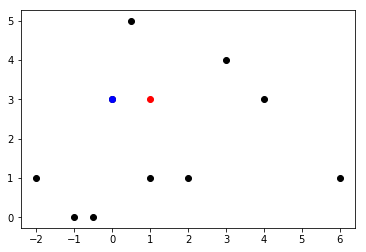

In [40]:
closest_to_query, _ = closest_point(X, query, dist)
print("Query: {}\nClosest to query: {}".format(query,closest_to_query))
plt.scatter(x_components, y_components, color="black")
plt.scatter(query[0], query[1], color="red")
plt.scatter(closest_to_query[0], closest_to_query[1], color="blue", linewidths=1, marker="o")

In [41]:

def closest_point_(all_points, new_point):
    best_point = None
    best_distance  = None
    
    for current_point in all_points:
        current_distance = distance(new_point, current_point)
        
        if best_distance is None or current_distance<best_distance:
            best_distance = current_distance
            best_point = current_point
            
    return best_point

In [42]:
closest_point_(X, query)

array([0., 3.])

- sort all the points by an axis (each iteration change the axis)
- find the median, split the points


To change the axis use a modulus operation


In [43]:
n_axis = 3
0%3,1%3,2%3,3%3

(0, 1, 2, 0)

In [44]:
k = 2

def build_kdtree(points, depth=0):
    n = len(points)
    
    if n<=0:
        return None
    
    axis = depth%k
    sorted_points = sorted(points, key= lambda point:point[axis])

    midpoint = int(n/2)
    
    return {
             "point": sorted_points[midpoint],
             "left":build_kdtree(sorted_points[:midpoint], depth+1),
             "right":build_kdtree(sorted_points[(midpoint+1):], depth+1)
           }



In [45]:
points = [list(x) for x in X]
points = [x for x in X]

In [46]:
points

[array([1., 1.]),
 array([0., 3.]),
 array([4., 3.]),
 array([-0.5,  0. ]),
 array([0.5, 5. ]),
 array([6., 1.]),
 array([-2.,  1.]),
 array([3., 4.]),
 array([2., 1.]),
 array([-1.,  0.])]

Query: [1 3]
Closest to query: [0. 3.]


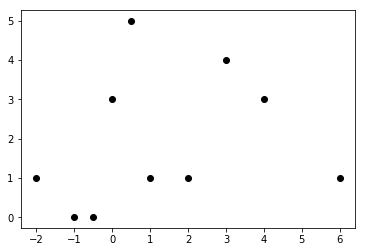

In [47]:
closest_to_query, _ = closest_point(X, query, dist)
print("Query: {}\nClosest to query: {}".format(query,closest_to_query))
plt.scatter(x_components, y_components, color="black")

In [48]:
kd_tree = build_kdtree(points)
kd_tree

{'left': {'left': {'left': {'left': None,
    'point': array([-1.,  0.]),
    'right': None},
   'point': array([-0.5,  0. ]),
   'right': None},
  'point': array([-2.,  1.]),
  'right': {'left': {'left': None, 'point': array([0., 3.]), 'right': None},
   'point': array([0.5, 5. ]),
   'right': None}},
 'point': array([1., 1.]),
 'right': {'left': {'left': {'left': None,
    'point': array([2., 1.]),
    'right': None},
   'point': array([6., 1.]),
   'right': None},
  'point': array([4., 3.]),
  'right': {'left': None, 'point': array([3., 4.]), 'right': None}}}

### Plotting a binary tree


The following post on stackoverflow provides an easy way to convert a binary tree stored in a dictionary graphically:

- https://stackoverflow.com/questions/13688410/dictionary-object-to-decision-tree-in-pydot

- You need to install `brew install graphviz`

In [77]:
#Using a recursive function

#You might want to consider using a recursive function (like the visit in my code below, so that you are able to process a general nested dictionary. In this function, you want to pass a parent parameter to keep track of who is your incoming node. Also note you use isinstance to check if the dictionary value of a key is a dictionary of its own, in that case you need to call your visit recursively.

import pydot

menu = {'dinner':
            {'chicken':'good',
             'beef':'average',
             'vegetarian':{
                   'tofu':'good',
                   'salad':{
                            'caeser':'bad',
                            'italian':'average'}
                   },
             'pork':'bad'}
        }

def draw(parent_name, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)

def visit(node, parent=None):
    for k,v in node.items():
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            if parent:
                draw(parent, k)
            visit(v, k)
        else:
            draw(parent, k)
            # drawing the label using a distinct name
            draw(k, k+'_'+v)



In [80]:
graph = pydot.Dot(graph_type='graph')
visit(menu)
graph.write_svg('example1_graph.svg')

![title](example1_graph.svg)

## Plotting our Kd-tree

In [70]:
kd_tree = build_kdtree(points)
kd_tree

{'left': {'left': {'left': {'left': None,
    'point': array([-1.,  0.]),
    'right': None},
   'point': array([-0.5,  0. ]),
   'right': None},
  'point': array([-2.,  1.]),
  'right': {'left': {'left': None, 'point': array([0., 3.]), 'right': None},
   'point': array([0.5, 5. ]),
   'right': None}},
 'point': array([1., 1.]),
 'right': {'left': {'left': {'left': None,
    'point': array([2., 1.]),
    'right': None},
   'point': array([6., 1.]),
   'right': None},
  'point': array([4., 3.]),
  'right': {'left': None, 'point': array([3., 4.]), 'right': None}}}

In [71]:
# kd_tree

In [72]:
def change_key(dictionary):
    for k, v in dictionary.items():
        if isinstance(v, dict):
            change_key(v)
            #import pdb;pdb.set_trace()
        if isinstance(dictionary[k], np.ndarray):
            print(dictionary[k])
            dictionary[k] = str(list(dictionary[k]))
        if dictionary[k] is None:
            dictionary[k] = "None"



change_key(kd_tree)

[1. 1.]
[-2.  1.]
[-0.5  0. ]
[-1.  0.]
[0.5 5. ]
[0. 3.]
[4. 3.]
[6. 1.]
[2. 1.]
[3. 4.]


In [73]:
kd_tree

{'left': {'left': {'left': {'left': 'None',
    'point': '[-1.0, 0.0]',
    'right': 'None'},
   'point': '[-0.5, 0.0]',
   'right': 'None'},
  'point': '[-2.0, 1.0]',
  'right': {'left': {'left': 'None', 'point': '[0.0, 3.0]', 'right': 'None'},
   'point': '[0.5, 5.0]',
   'right': 'None'}},
 'point': '[1.0, 1.0]',
 'right': {'left': {'left': {'left': 'None',
    'point': '[2.0, 1.0]',
    'right': 'None'},
   'point': '[6.0, 1.0]',
   'right': 'None'},
  'point': '[4.0, 3.0]',
  'right': {'left': 'None', 'point': '[3.0, 4.0]', 'right': 'None'}}}

In [76]:
graph = pydot.Dot(graph_type='graph')
visit(kd_tree)
#graph.write_png('kd_tree.png')

![title](kd_tree.png)

## Inspecting first split point

Let us see if the splitpoint matches our intuition

In [163]:

axis=0
sorted_points = sorted(points, key= lambda point:point[axis])
midpoint = int(len(X)//2)
print(midpoint)
x_node = sorted_points[midpoint] # the number midpoint+1 element (python counts from 0)

5


Let us inspect the rest of the tree.

So far we have checked that the middle point is [1,1]

In [164]:
kd_tree["point"]

array([1., 1.])

what is on the left hand side?

In [165]:
left_of_first_node = [np.array([-1.,  0.]),
                      np.array([-0.5,  0. ]),
                      np.array([-2.,  1.]),
                      np.array([ 0.,  3.]),
                      np.array([ 0.5,  5. ])]

# Plotting points uder the left hand side of the first node

In [59]:
def get_left_points(kd_tree, left_points=None):
    if left_points is None:
        left_points = []
    
    if kd_tree is None:
        return left_points
    
    if "left" in kd_tree:
        left_points.append(kd_tree["point"])
        get_left_points(kd_tree["left"], left_points)
    
    return left_points

In [60]:
aux = get_left_points(kd_tree)
aux

[array([1., 1.]), array([-2.,  1.]), array([-0.5,  0. ]), array([-1.,  0.])]

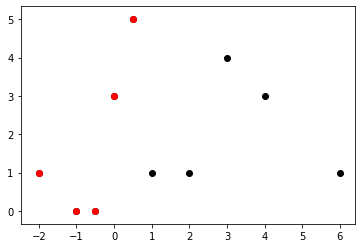

In [61]:
closest_to_query, _ = closest_point(X, query, dist)

#X = np.array([[1,1],[0,3],[4,3],[0,0],[1,5],[6,1],[-2,1],[4,4],[2,1],[-1,0]])
X = np.array([[1,1],[0,3],[4,3],[-0.5,0],[0.5,5],[6,1],[-2,1],[3,4],[2,1],[-1,0]])

x_components = [x[0] for x in X]
y_components = [x[1] for x in X]
plt.scatter(x_components, y_components, color="black")

x_components = [x[0] for x in left_of_first_node ]
y_components = [x[1] for x in left_of_first_node ]

plt.scatter(x_components, y_components, color="red")

In [62]:
import pprint
pp = pprint.PrettyPrinter()
pp.pprint(kd_tree)

{'left': {'left': {'left': {'left': None,
                            'point': array([-1.,  0.]),
                            'right': None},
                   'point': array([-0.5,  0. ]),
                   'right': None},
          'point': array([-2.,  1.]),
          'right': {'left': {'left': None,
                             'point': array([0., 3.]),
                             'right': None},
                    'point': array([0.5, 5. ]),
                    'right': None}},
 'point': array([1., 1.]),
 'right': {'left': {'left': {'left': None,
                             'point': array([2., 1.]),
                             'right': None},
                    'point': array([6., 1.]),
                    'right': None},
           'point': array([4., 3.]),
           'right': {'left': None, 'point': array([3., 4.]), 'right': None}}}


In [63]:

def distance(x1: np.ndarray, x2: np.ndarray):
    return np.linalg.norm((x1-x2)**2)

In [64]:

def closer_distance(pivot, p1, p2):
    if p1 is None:
        return p2
    if p2 is None:
        return p1
    
    d1 = distance(pivot, p1)
    d2 = distance(pivot, p2)
    
    if d1 <d2:
        return p1
    else: 
        return p2
    
    
def kdtree_closest_point(root, point, depth=0):
    if root is None:
        return None
    
    axis = depth%k

    next_branch     = None
    opposite_branch = None
    
    #import pdb;pdb.set_trace()
    #print(axis, type(axis), type(root))
    #print( point[axis],root["point"])
    
    if point[axis] < root["point"][axis]:
        next_branch = root["left"]
        oposite_branch = root["right"]
    else:
        next_branch = root["right"]
        opposite_branch = root["left"]
        
    best = closer_distance(point,
                           kdtree_closest_point(next_branch,
                                                point, 
                                                depth+1),
                           root["point"])
    
    if  distance(point, best) > abs(point[axis] - root["point"][axis]):
    #if  distance(point, best) > distance(point, root["point"]):
        best = closer_distance(point,
                               kdtree_closest_point(next_branch,
                                                point, 
                                                depth+1),
                               best)
       
    return best
    

In [65]:
q = query
q

array([1, 3])

In [66]:
kdtree_closest_point(kd_tree, q)

array([1., 1.])

Query: [1 3]
Closest to query: [0. 3.]


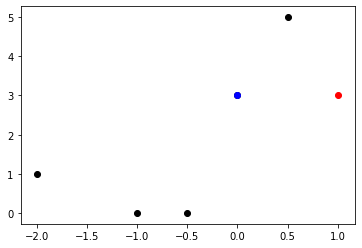

In [67]:
closest_to_query, _ = closest_point(X, query, dist)
print("Query: {}\nClosest to query: {}".format(query,closest_to_query))
plt.scatter(x_components, y_components, color="black")
plt.scatter(query[0], query[1], color="red")
plt.scatter(closest_to_query[0], closest_to_query[1], color="blue", linewidths=1, marker="o")

### kdtree in sklearn

In [68]:
np.random.seed(1234)
X = np.random.rand(1000000,10).astype(np.float32)
x = np.random.rand(1,10).astype(np.float32)

In [69]:
%time distances =  np.mean((X-x)**2,1)

CPU times: user 48.7 ms, sys: 18 ms, total: 66.6 ms
Wall time: 65 ms


In [70]:
%time closest = np.argmin(np.mean((X-x)**2,1))
print("\nclosest row from x is {}".format(closest))

CPU times: user 45.3 ms, sys: 7.11 ms, total: 52.5 ms
Wall time: 50.6 ms

closest row from x is 888194


In [71]:
import sklearn
from sklearn import *

In [72]:
%time tree = sklearn.neighbors.KDTree(X, leaf_size=1_000_000)

CPU times: user 45.9 ms, sys: 20.9 ms, total: 66.8 ms
Wall time: 67.5 ms


In [73]:
%time distance_to_closest, closest_kdtree = tree.query(x,k=1)

CPU times: user 14.5 ms, sys: 1.39 ms, total: 15.9 ms
Wall time: 14.8 ms


In [74]:
print("\nclosest row from x is {}".format(closest_kdtree[0][0]))


closest row from x is 888194
